In [43]:
import os
import glob
import pandas as pd
import numpy as np
from skimage.io import imread
from skimage.io import imsave
from skimage.segmentation import find_boundaries
from utils import run_mesmer
from utils import imshow
from utils import side_by_side

from matplotlib import rcParams
rcParams['figure.dpi']=200

## Select sample

In [96]:
SAMPLE = 'TNP_pilot_cycif'
# SAMPLE = 'PilotTonsil_5_z08' # This is the codex sample, folder was renamed to match the actual files coming out from the mcmicro run. 

DATA_DIR = f'data/{SAMPLE}' 

images = sorted(glob.glob(f"{DATA_DIR}/*/*subset*tif") + glob.glob(f"{DATA_DIR}/*/unmicst*/*subset*tif"))
images

['data/TNP_pilot_cycif/registration/TNP_pilot_cycif_subset.ome.tif',
 'data/TNP_pilot_cycif/segmentation/unmicst-TNP_pilot_cycif/cellMask_subset.tif']

## Load ome-tiff subset

In [77]:
im_tiff = imread(images[0])

## Load markers

In [80]:
df = pd.read_csv(f'{DATA_DIR}/markers.csv')

if SAMPLE == 'PilotTonsil_5_z08':
    df = pd.read_csv(f'{DATA_DIR}/markers.csv', header=None)
    df.columns = ['marker_name']

# Create dictionaries to map between channel and index
chn2idx = {df.marker_name[i]:i for i in range(len(df))}
idx2chn = {i:df.marker_name[i] for i in range(len(df))}
df.marker_name

0           Hoechst1
1               A488
2               A555
3               A647
4           Hoechst2
5     anti_NaKATPase
6           anti_CD3
7        anti_CD45RO
8           Hoechst3
9           Ki67_488
10       Keratin_570
11          aSMA_660
12          Hoechst4
13          CD8a_488
14           CD4_570
15          CD45_647
16          Hoechst5
17          CD20_488
18         CD11c_555
19           PD1_647
20          Hoechst6
21          CD68_488
22         FOXP3_570
23          PDL1_647
24          Hoechst7
25         CD163_488
26             H3_PE
27          CD31_647
28          Hoechst8
29          Ecad_488
30      Vimentin_555
31       Catenin_647
32          Hoechst9
33       LaminAC_488
34           pH3_555
35          H2ax_647
Name: marker_name, dtype: object

In [99]:
# Review each channel

# for i in range(40):
#     print (df.marker_name[i])
#     imshow(im_tiff[i,...], figwidth=3, resize=False)

## Select the nuclear channel and membrane channel as Mesmer input

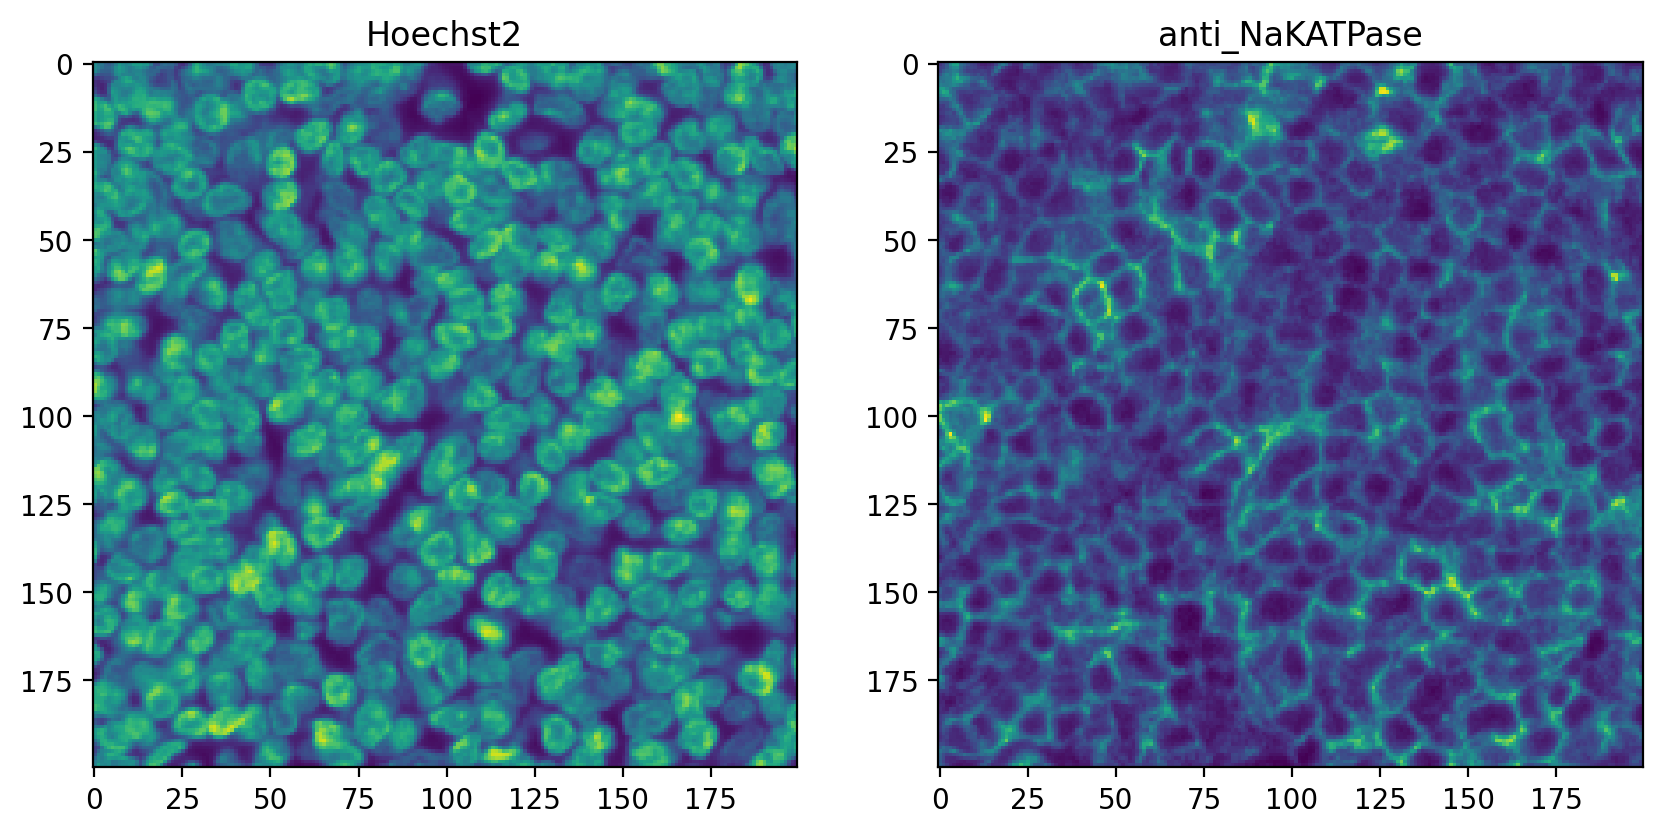

In [98]:
if SAMPLE == 'TNP_pilot_cycif':
    nuclear_marker = 'Hoechst2'
    membrane_marker = 'anti_NaKATPase'
elif SAMPLE == 'PilotTonsil_5_z08':
    nuclear_marker = 'DNA1'
    membrane_marker = 'CD45(Dom)'
    
im_nuclear = im_tiff[chn2idx[nuclear_marker],...]
im_membrane = im_tiff[chn2idx[membrane_marker],...]

side_by_side(im_nuclear, im_membrane, (10,5), nuclear_marker, membrane_marker, resize=False)

## Run mesmer

In [83]:
mask, boundary = run_mesmer(im_nuclear, im_membrane,compartment='whole-cell')

start mesmer process...


generating mask...
mask is generated.


## Save mesmer segmentation mask

In [85]:
mesmer_folder = f"{DATA_DIR}/segmentation/mesmer-{SAMPLE}"
if not os.path.exists(mesmer_folder):
    os.makedirs(mesmer_folder)  
    
mask_fname = f"{mesmer_folder}/cell_Mask_subset.tif"
boundary_fname = f"{mesmer_folder}/cell_Boundary_subset.tif"

# Save
imsave(mask_fname,mask)
imsave(boundary_fname,boundary)

/tmp/ipykernel_2802/3230455926.py:9: UserWarning: data/TNP_pilot_cycif/segmentation/mesmer-TNP_pilot_cycif/cell_Mask_subset.tif is a low contrast image
  imsave(mask_fname,mask)


## Compare with provided (Unmicst): CyCIF and CODEX

TNP_pilot_cycif


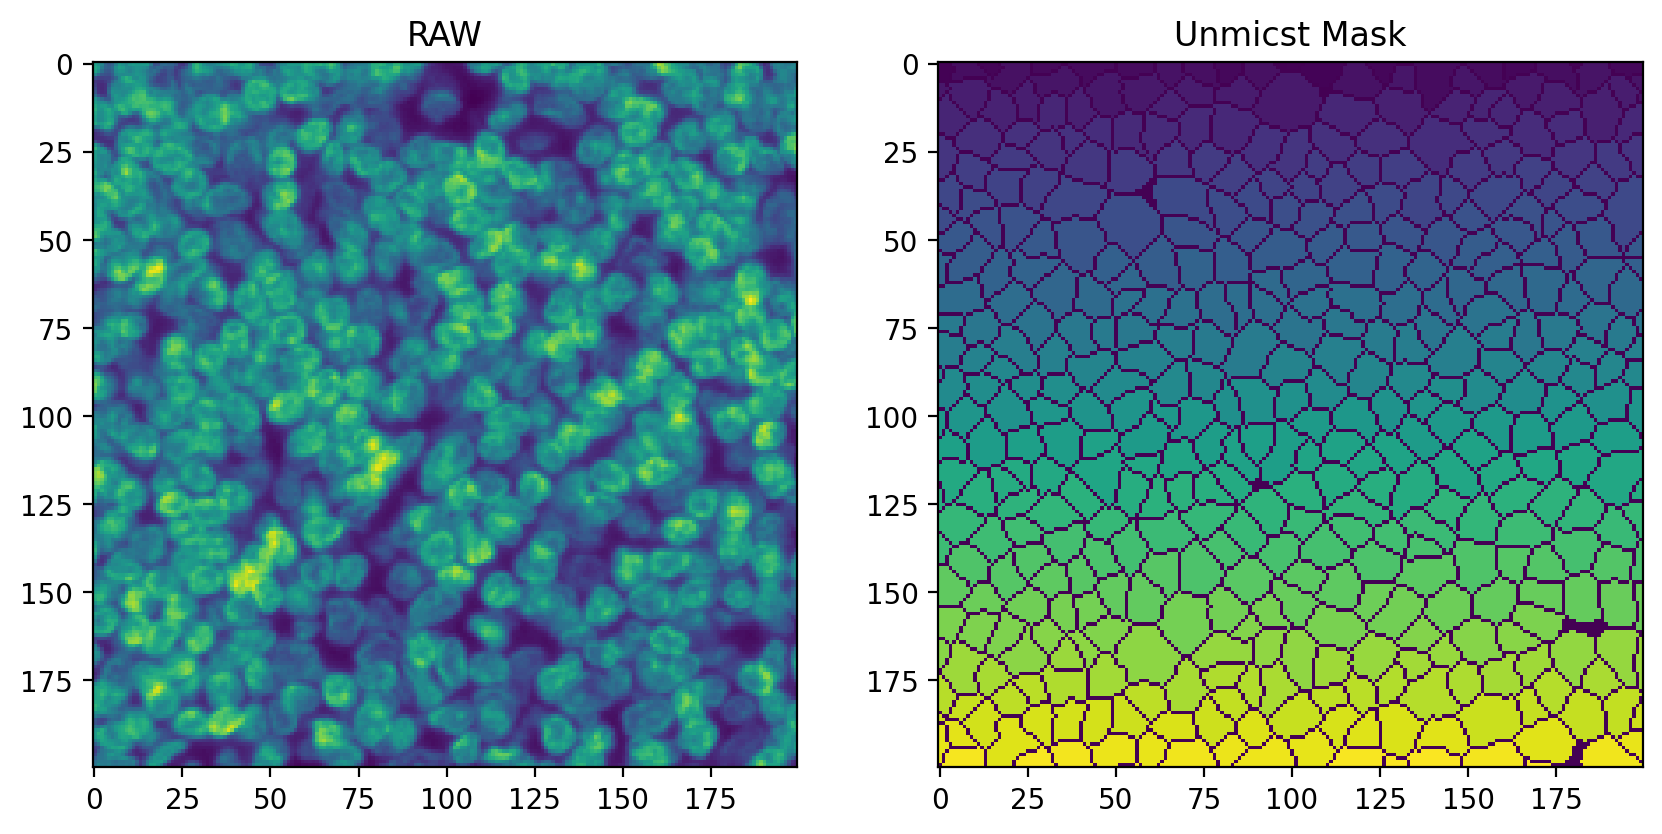

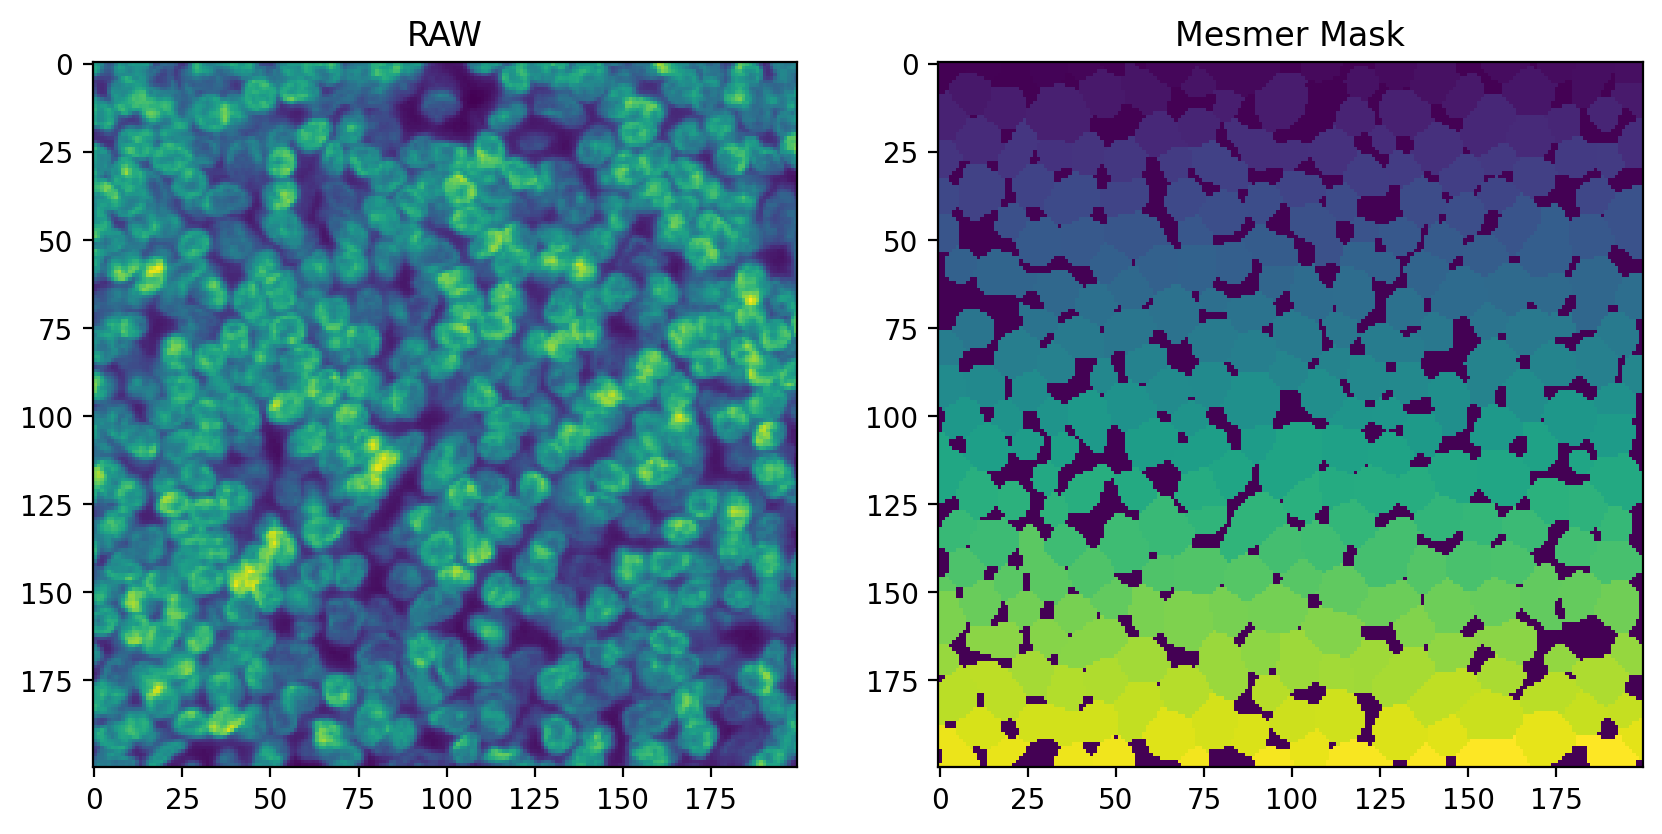

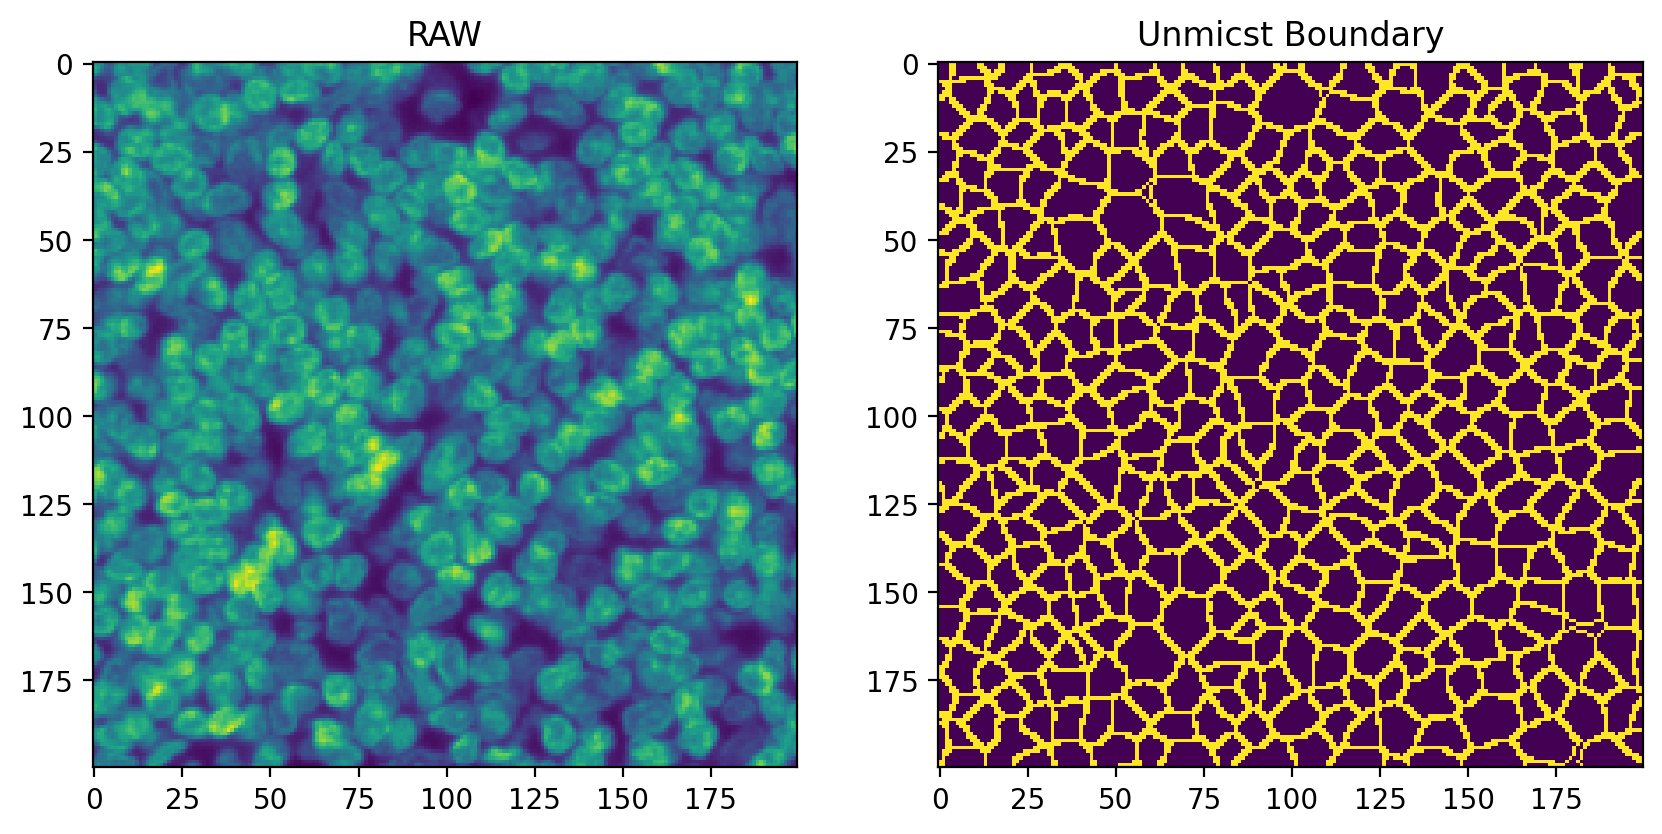

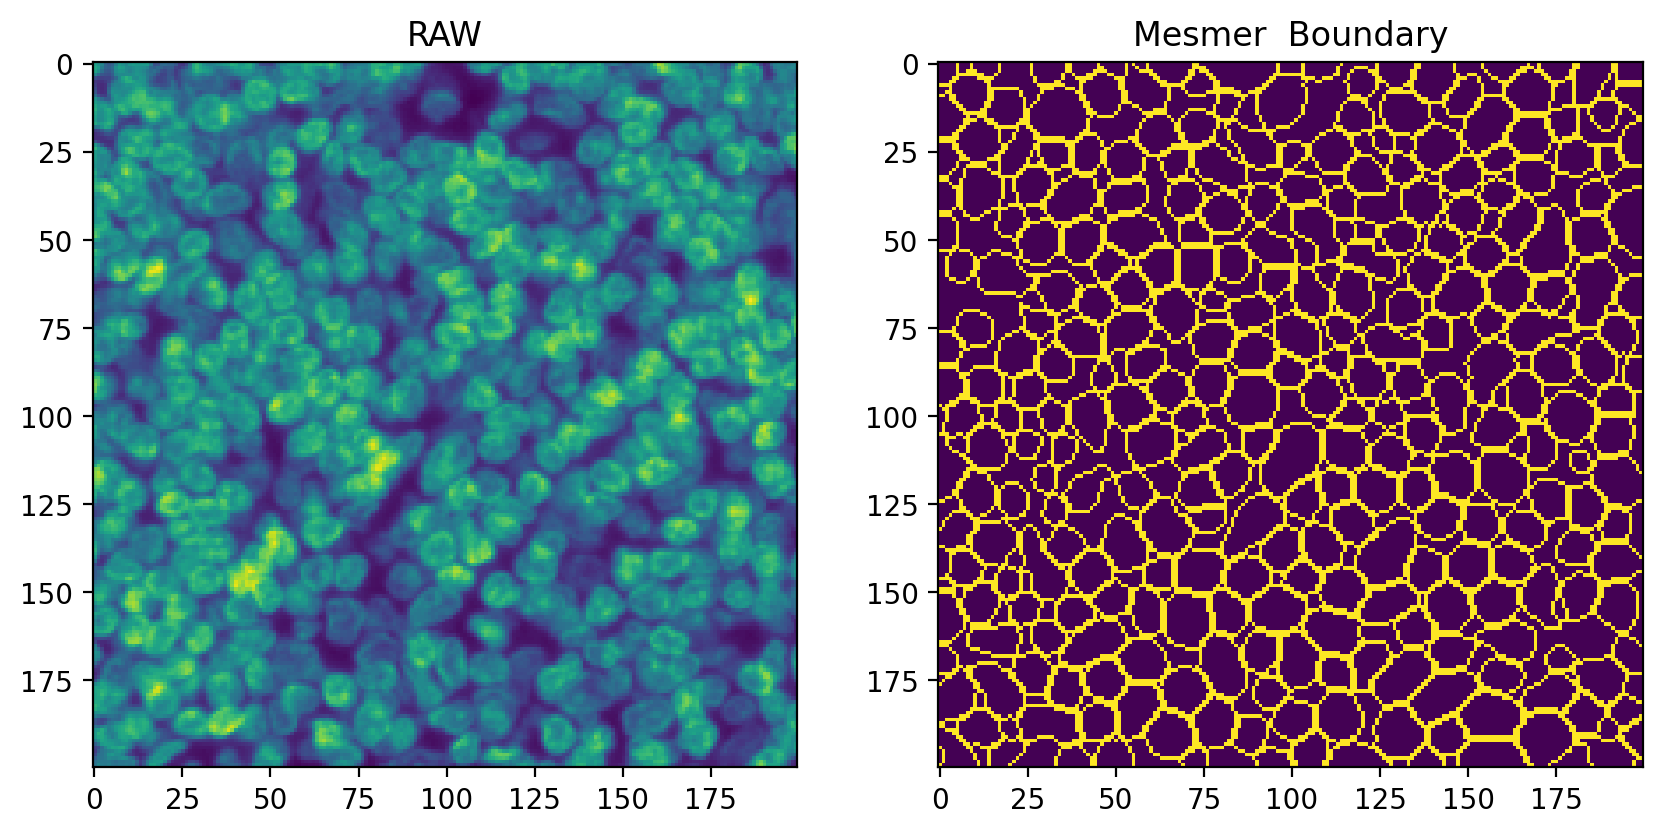

PilotTonsil_5_z08


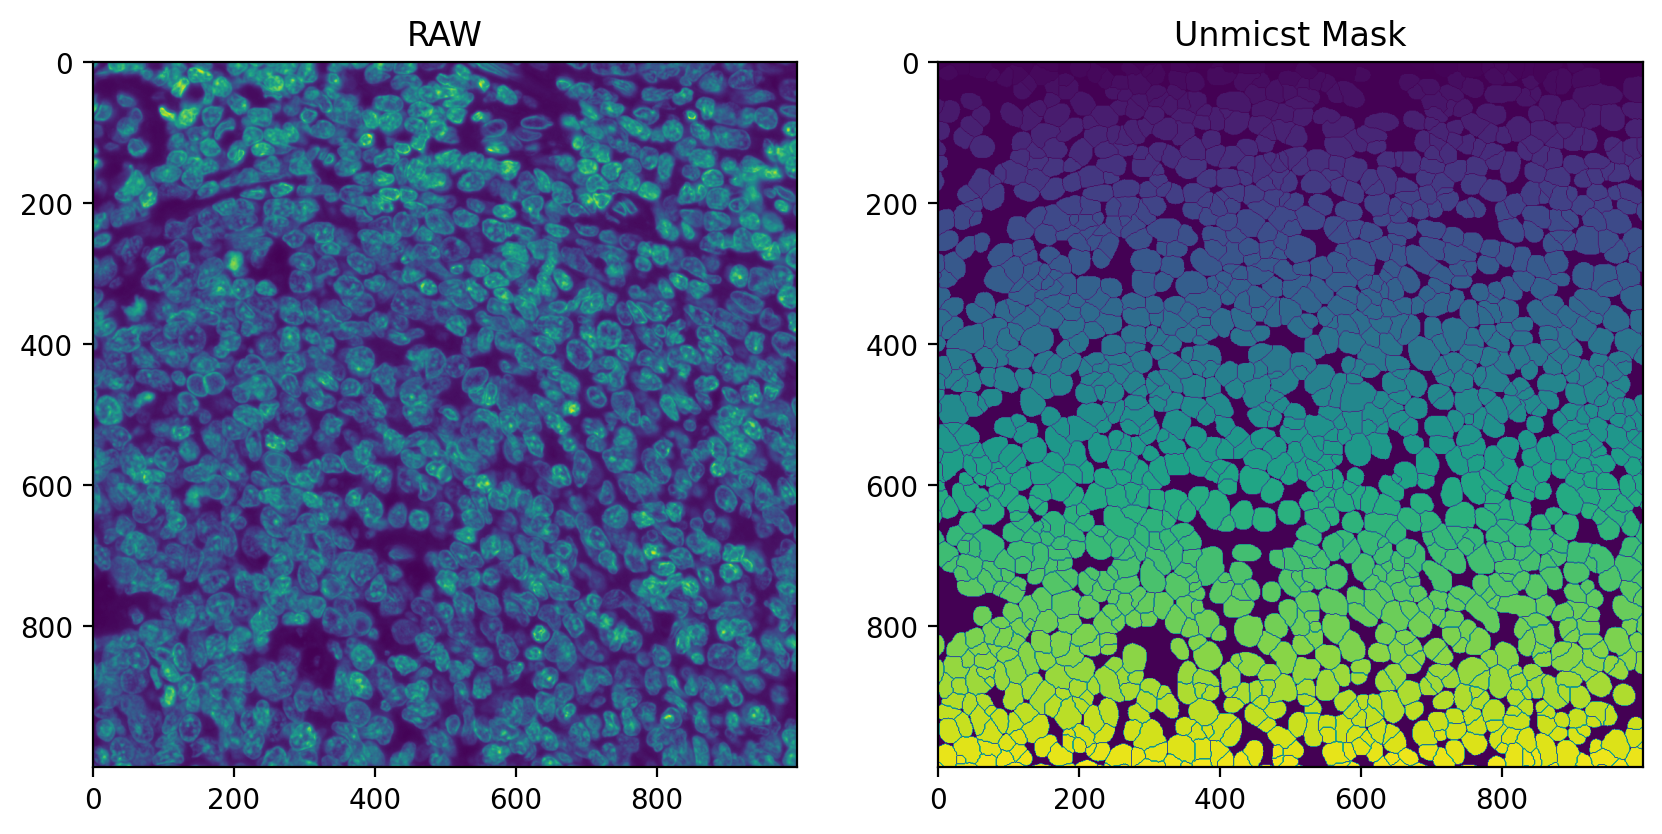

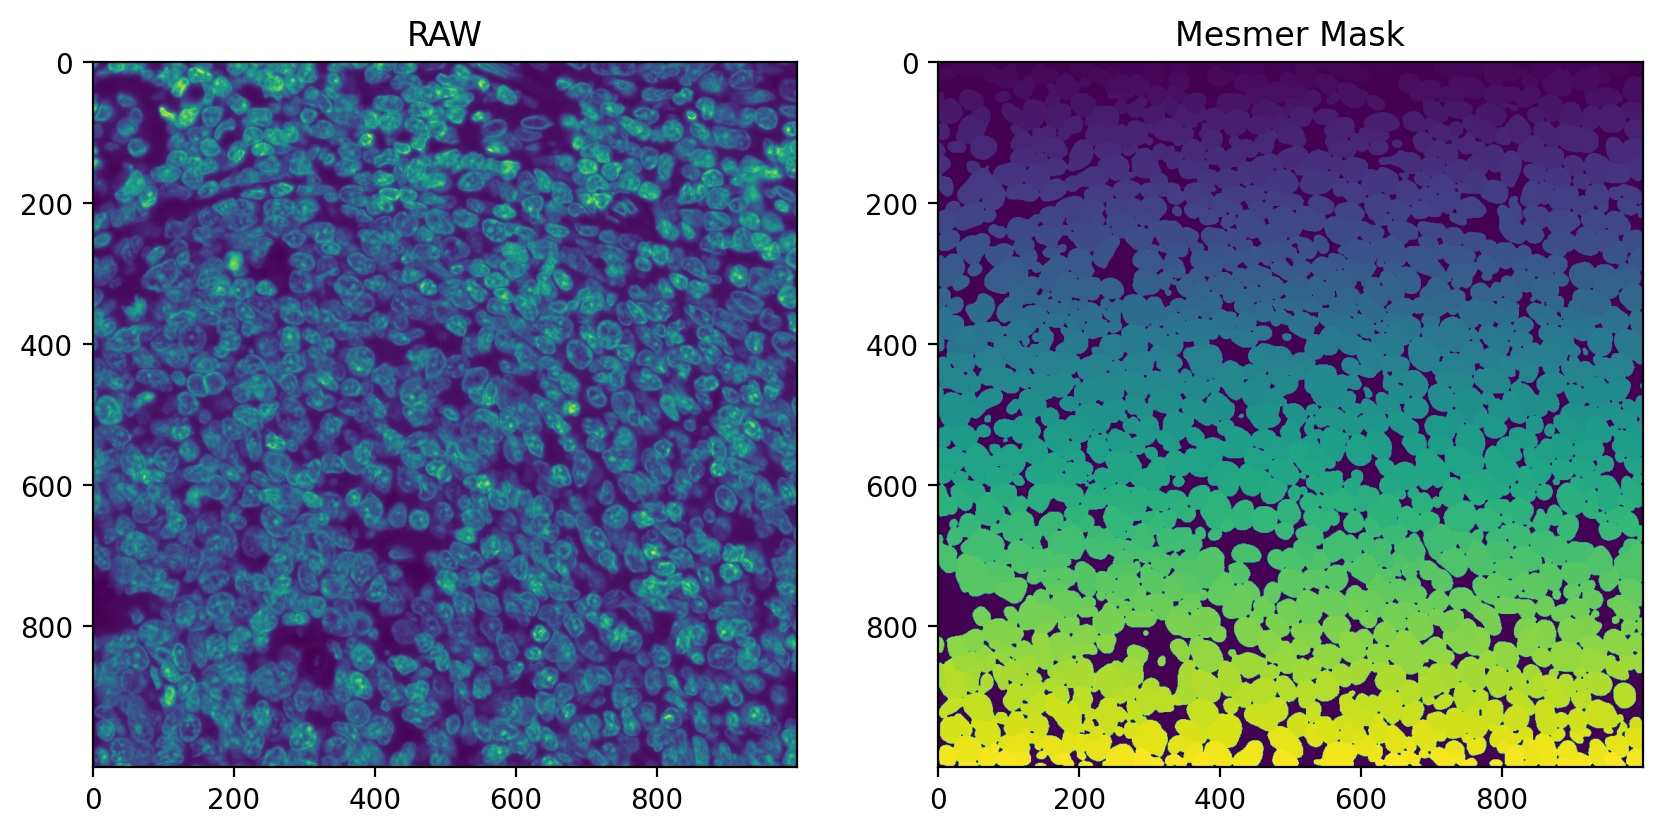

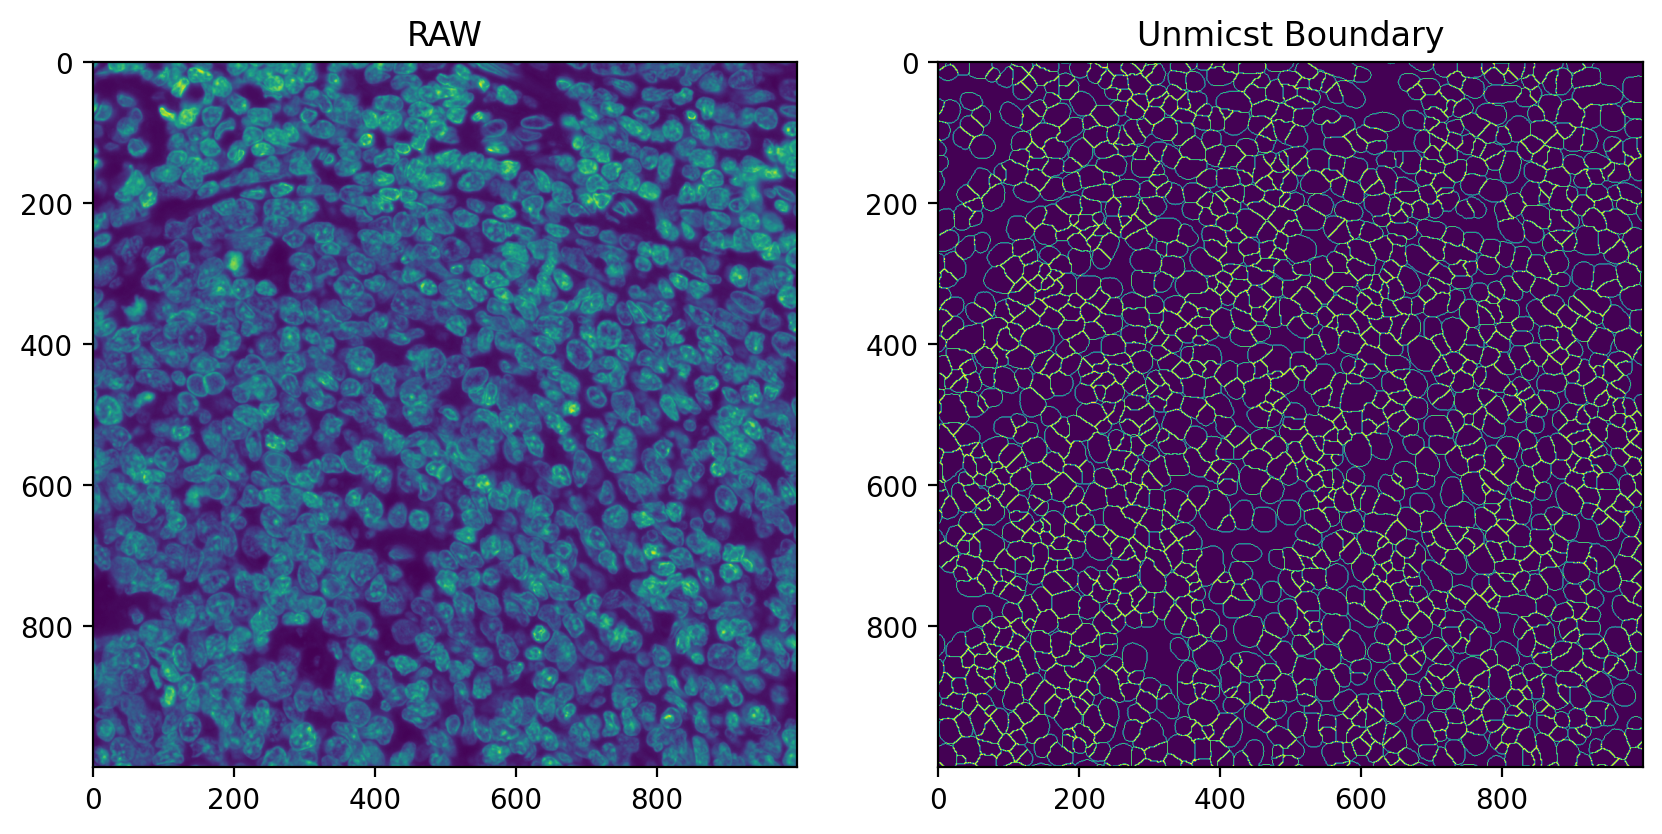

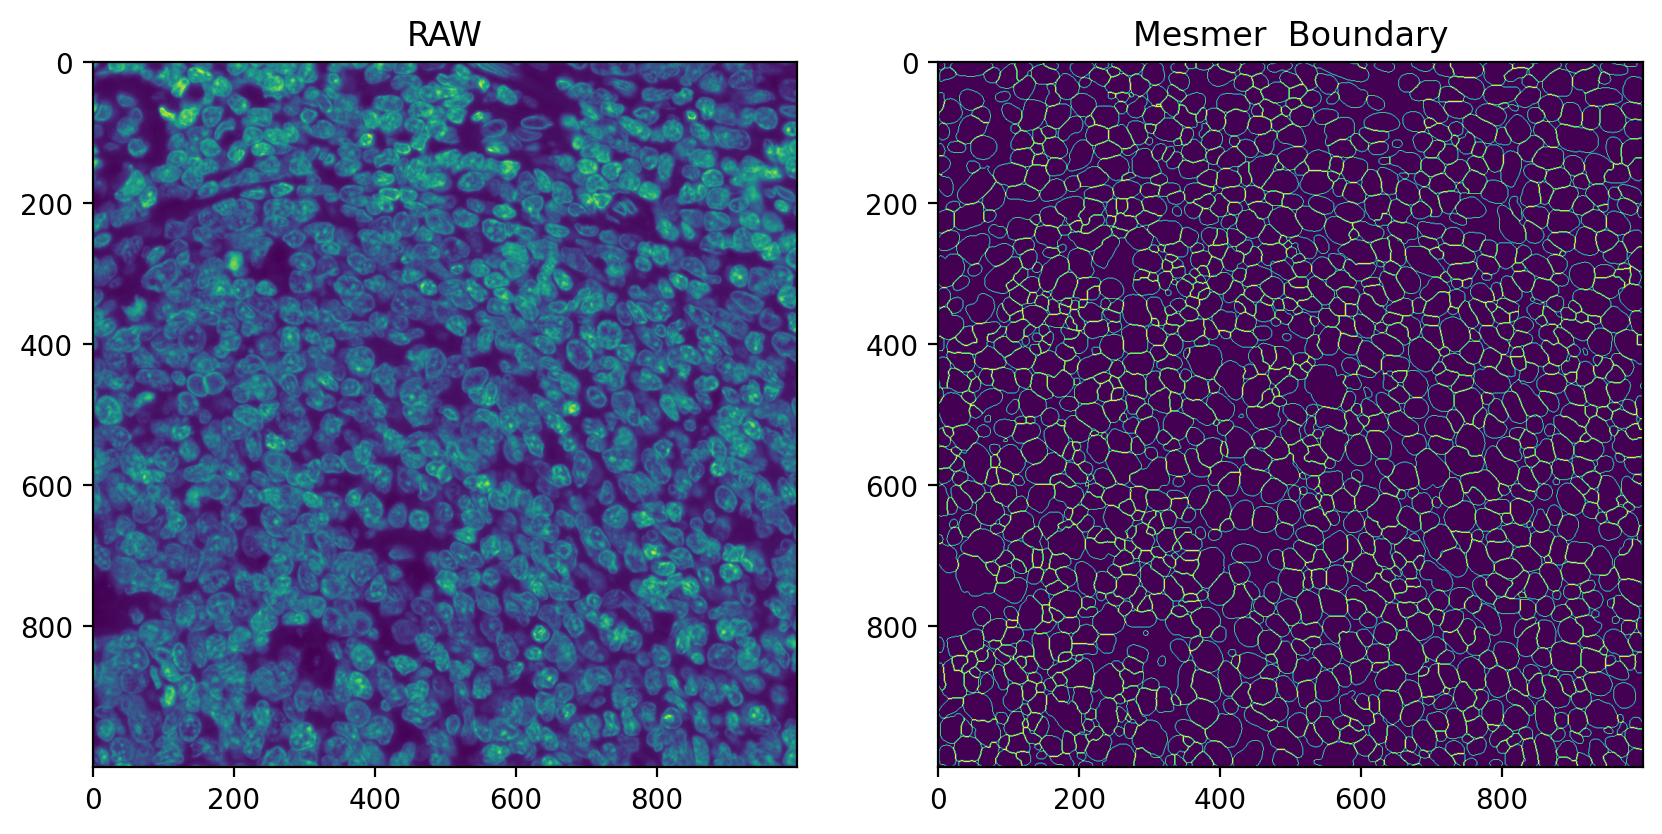

In [95]:
for SAMPLE in ['TNP_pilot_cycif', 'PilotTonsil_5_z08']:
    figsize=(10,5)
    print (SAMPLE)
    DATA_DIR = f'data/{SAMPLE}' 
    
    images = sorted(glob.glob(f"{DATA_DIR}/*/*subset*tif") + glob.glob(f"{DATA_DIR}/*/*/*subset*tif"))

    # Nuclear channel
    im_nuclear = imread(images[0])[0,...]   

    # Unmicst segmentation mask
    mask_unmicst = imread(images[3])
    lb = 0
    for i in sorted(np.unique(mask_unmicst)):
        mask_unmicst = np.where(mask_unmicst == i, lb, mask_unmicst)
        lb+=1
    # Unmicst boundary    
    boundary_unmicst = find_boundaries(mask_unmicst, connectivity=1, mode='outer').astype(float)    

    # Mesmer segmentation mask
    mask_mesmer = imread(images[2])    

    # Mesmer segmentation boundary
    boundary_mesmer = imread(images[1])        

    side_by_side(im_nuclear, mask_unmicst, figsize, 'RAW', 'Unmicst Mask', resize=False)
    side_by_side(im_nuclear, mask_mesmer, figsize, 'RAW', 'Mesmer Mask', resize=False)

    side_by_side(im_nuclear, boundary_unmicst, figsize, 'RAW', 'Unmicst Boundary', resize=False)
    side_by_side(im_nuclear, boundary_mesmer, figsize, 'RAW', 'Mesmer  Boundary', resize=False)
